&nbsp;

# 2. Base Models
Whenever conducting empirical testing, it is always a good idea to have a point of reference to compare against, this can come in the form of a benchmark. A benchmark is something that serves as a standard by which others may be measured or judged. In the world of machine learning, benchmarks don’t have to consist of world class models, on the contrary a good starting point is always the default algorithms. The point of having a benchmark is to test out our hypotheses to analyze whether our assumptions measure up and perform the way we hypothesize.

In [1]:
# Standard libraries. 
import pandas as pd
import numpy as np 
import os
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

# Importing functions. 
import visuals

# Importing models. 
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold

# Importing transformers. 
from sklearn.preprocessing import LabelEncoder 

# Converts plotly output into static images, so it can be viewed inside github repository. 
import plotly.io as pio
pio.renderers.default = "svg"

In [2]:
root = os.getcwd() # Set up root directory.
df = pd.read_csv(r"{}\train.csv".format(root)) # Import train data. 
df = df.set_index("id") # Set paitent id as index. 
df.head(2)

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
id,,,,,,,,,,,,,,,,,,,,,
896864,12.98,19.35,84.52,514.0,0.09579,0.11250,0.07107,0.02950,0.1761,0.06540,...,21.95,99.21,634.3,0.1288,0.32530,0.34390,0.09858,0.3596,0.09166,0
89382601,14.61,15.69,92.68,664.9,0.07618,0.03515,0.01447,0.01877,0.1632,0.05255,...,21.75,103.70,840.8,0.1011,0.07087,0.04746,0.05813,0.2530,0.05695,0


&nbsp;

### Section A: Base Model Testing
In this section we will be exploring a variety of Machine Learning algorithms and how well they perform with our newly processed data. We'll pick out the top 3 best performing models and use them as our benchmarks, when conducting hypotheses. Since our data contains only numerical features with no missing values we won't need to set up a pipeline to preprocess the data. 

**A.1: Data Preparation**<br>
Before we can conduct empirical tests on our array of algorithms we must first prepare the data. This entails splitting it into features and labels, and encoding the target variable into binary values. We'll be using the LabelEncoder function from the scikit-learn library.

In [3]:
# Determining if our labelled data is imbalanced.
count = df.groupby(["diagnosis"]).agg({"diagnosis":"count"}) # Aggregating labels by count. 
count

,diagnosis
diagnosis,
0,291
1,164


* It seems we have an imbalanced class label with 291 benign and 164 malignant labels.

In [4]:
# Encoding our target variable into binary values (0, 1).
le = LabelEncoder() # LabelEncoder instance. 
df["diagnosis"] = le.fit_transform(df["diagnosis"]) # Transforming our label using LabelEncoder.

filterLabel = list(df.columns) # Storing all features into a list.
filterLabel.remove("diagnosis") # Removing "diagnosis" from our filter. 

# Splitting the data into features and label. 
X = df[filterLabel] # Filtering dataframe to exclude label. 
y = df["diagnosis"] # Label. 

**A.2: Testing Base Models**<br>
The next step is to test a variety of classification algorithms pick the top 3 best performing models. But first we must decide which evaluation metric we'll be using.

In the field of medicine it is always safe to optimize for Recall because it would always be better diagnosing a paitent for a disease they don't have rather than classifying them as healthy when they actually do have the disease. The latter can have serious repercussions. Since our label is an imbalanced dataset, we'll be using the recall_weighted scoring function.

In [5]:
results = list() # Store cross validated test scores of each model. 
modelNames = ['CART', 'LR', 'Per', 'KNN', 'RFC', 'GBC', 'XGBC', 'SVC'] # Model strings. 
modelInstance = [DecisionTreeClassifier(), LogisticRegression(max_iter=5000), Perceptron(), KNeighborsClassifier(), 
                 RandomForestClassifier(), GradientBoostingClassifier(), XGBClassifier(), SVC()]
modelScores = {} # For later use to set up benchmarks. 

# Iterate through each model and record their recall score. 
for name, model in zip(modelNames,modelInstance):    
    model.fit(X, y) # Training the model. 
    # StratifedKFold preserves the distribution of the population with each sample fold. 
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # 5 fold strategy.
    # Enable "return_train_score" to see if model overfitted.
    cv_results = cross_validate(model, X, y, cv=cv, scoring='recall_weighted', return_train_score=True) 
    results.append(cv_results['test_score']) # Appending results of each fold into a list for later visualization. 
    print("%s scored an recall train score of: %.2f%% and a test score of: %.2f%%" % (name, 
                                                                                  cv_results['train_score'].mean()*100, 
                                                                                  cv_results['test_score'].mean()*100))
    
    # Storing results to use as benchmark values.
    modelScores[name] = round(cv_results['test_score'].mean()*100,4)

CART scored an recall train score of: 100.00% and a test score of: 91.65%
LR scored an recall train score of: 96.54% and a test score of: 95.38%
Per scored an recall train score of: 82.75% and a test score of: 81.98%
KNN scored an recall train score of: 95.16% and a test score of: 93.19%
RFC scored an recall train score of: 100.00% and a test score of: 96.04%
GBC scored an recall train score of: 100.00% and a test score of: 95.60%
XGBC scored an recall train score of: 100.00% and a test score of: 95.38%
SVC scored an recall train score of: 92.25% and a test score of: 92.31%


**A.3: Table of Results**<br>
Based on the results, the three models I will choose are: Gradient Boosting Classifier, Random Forest Classifier and the XGB Classifier. Even though these models overfitted, they are tree ensemble methods, which means we can implement various techniques to remove overfitting.

| Model | Train f1_score | Validation f1_score | Overfit | Accept Model |
|---------|---------|---------|---------|---------|
| **Decision Tree** | 100% | 92.31% |✔️ |❌ |
| **Logistic Regression** | 96.54% | 95.38% |❌ |❌ |
| **Perceptron** | 82.75% | 81.98% |❌ |❌ |
| **K Neighbors Classifier** | 95.16% | 93.19% |❌ |❌ |
| **Random Forest Classifier** | 100% | 95.38% |✔️ |✔️ |
| **Gradient Boosting Classifier** | 100% | 95.82% |✔️ |✔️ |
| **XGB Classifier** | 100% | 95.38% |✔️ |✔️ |
| **Support Vector Classifier** | 92.25% | 92.31% |❌ |❌ |

**A.3: Visualizing Results**<br>
We can plot the results of each fold into a boxplot and visualize the distribution over the 5 folds.

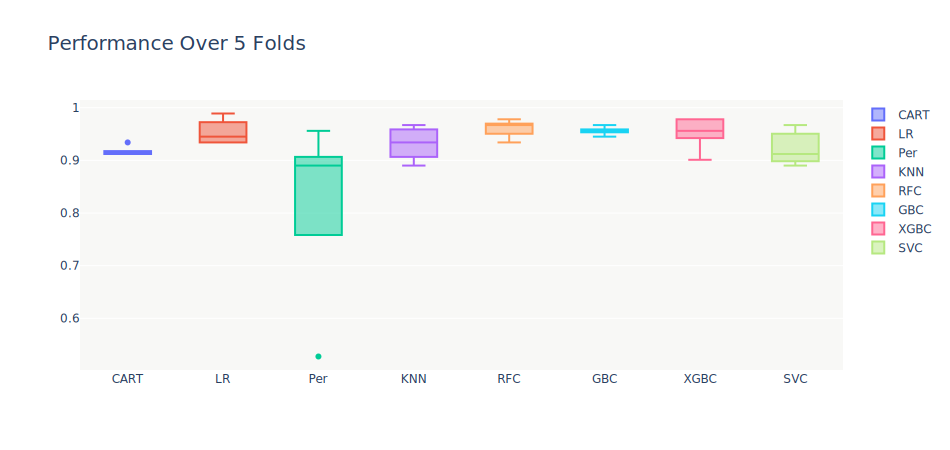

In [6]:
visuals.kfold(scores=results)

* It seems our Perceptron model had an extreme outlier in one of the folds with an f1 score of 0.55.
* Majoirty of the algorithms had their medians above the 90% range. 

&nbsp;

&nbsp;
**Author:** Aaron Chew&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **|** &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Date Published:** 11/08/2022 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**|** &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Email:** aaronsamuelchew@gmail.com &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**|**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **GitHub:** https://github.com/aaron-chew  